In [1]:
import numpy as np
import xarray as xray
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
from pop_gradient import agg_and_gradient
reload(agg_and_gradient)

<module 'pop_gradient.agg_and_gradient' from 'pop_gradient/agg_and_gradient.py'>

In [8]:
basedir = '/data/scratch/takaya/POP_data/Surface_Daily/'

In [142]:
fname = os.path.join(basedir, 
                                    'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-01-01.nc')
ds = xray.open_dataset(fname,
                      decode_times=False)
nroll = -1100
mask = ds.KMT > 1
SST46_01 = ds.SST.where(mask).roll(nlon=nroll)
lat = ds.TLAT.where(mask).roll(nlon=nroll)
lon = ds.TLONG.where(mask).roll(nlon=nroll)

In [138]:
ys = 200; ye = 1900
xs = 0; xe = 3500

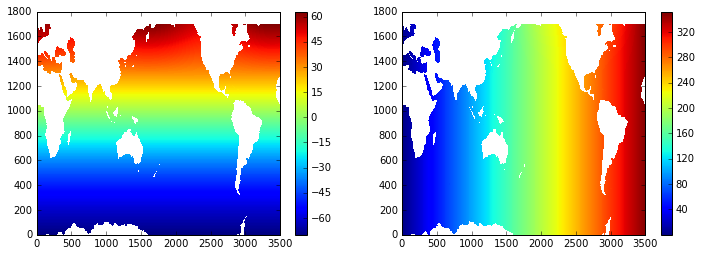

In [143]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(lat.values[ys:ye, xs:xe]))
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(lon.values[ys:ye, xs:xe]))
fig.colorbar(cax2)

In [48]:
p = agg_and_gradient.POPFile(fname)

In [13]:
p.initialize_gradient_operator()

pop_gradient/agg_and_gradient.py:105: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  self._ahf[self.mask] = 0.


In [23]:
print lat.roll(nlon=-1080).values.ravel()

[         nan          nan          nan ...,  82.58150235  82.54020015
  82.49890661]


In [144]:
lat_interp = p.interpolate_2d(np.ma.masked_invalid(lat.values[ys:ye, xs:xe]))
lon_interp = p.interpolate_2d(np.ma.masked_invalid(lon.values[ys:ye, xs:xe]))

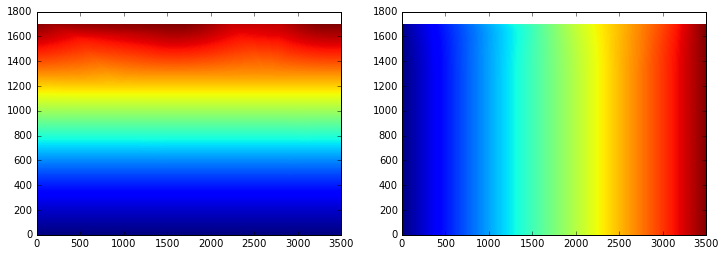

In [145]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax1.pcolormesh(np.ma.masked_invalid(lat_interp))
ax2 = fig.add_subplot(122)
ax2.pcolormesh(np.ma.masked_invalid(lon_interp))

In [147]:
print SST46_01.shape, lon_interp[200, :]-180.

(31, 2400, 3600) [-179.95 -179.85 -179.75 ...,  169.75  169.85  169.95]


In [153]:
SST_ex = SST46_01.copy()[:, ys:ye, xs:xe]
mask_ex = mask.roll(nlon=-1100).values[ys:ye, xs:xe]

In [119]:
# SST_ex[0,1400:1710, :600] = np.nan

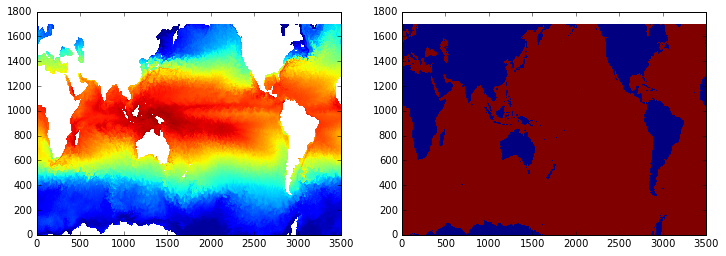

In [154]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax1.pcolormesh(np.ma.masked_invalid(SST_ex[0]))
ax2 = fig.add_subplot(122)
ax2.pcolormesh(np.ma.masked_invalid(mask_ex))

In [ ]:
south=-60.; north=60.; west=-180.; east=170.; dlon=1.; dlat=1.; 
SSTagg_ex = np.zeros((int((north-south)/dlat), int((east-west)/dlon)))
SSTagg_ex[:] = np.nan
print SSTagg_ex.shape

j = 0; s = south
while s < north:
    i = 0; w = west
    while w < east:
#         if j == 0:
#             print w
        lonrange = np.array([w, w+dlon])
        latrange = np.array([s, s+dlat])
        lonmask = ((lon_interp-180.) >= lonrange[0]) & ((lon_interp-180.) < lonrange[1])
        latmask = (lat_interp >= latrange[0]) & (lat_interp < latrange[1])
        boxidx = lonmask & latmask # this won't necessarily be square
        irange = np.where(boxidx.sum(axis=0))[0]
        imin, imax = irange.min(), irange.max()
        jrange = np.where(boxidx.sum(axis=1))[0]
        jmin, jmax = jrange.min(), jrange.max()
        if i == 0:
            print jmin, jmax
        
        region_mask = mask_ex[jmin:jmax, imin:imax]
        SSTagg_ex[j, i] = np.ma.mean(np.ma.masked_array(SST_ex[0, jmin:jmax, imin:imax], 
                                                        ~region_mask))
                
        w += dlon
        i += 1
    s += dlat
    j += 1

(120, 350)
228 246
247 266
267 284
285 302
303 320
321 337
338 354
355 370
371 386
387 402
403 418
419 433
434 447
448 462
463 476
477 490
491 504
505 518
519 531
532 544
545 557
558 570
571 582
583 595
596 607
608 619
620 631
632 643
644 655
656 666
667 678
679 689
690 700
701 712
713 723
724 734
735 745
746 755
756 766
767 777
778

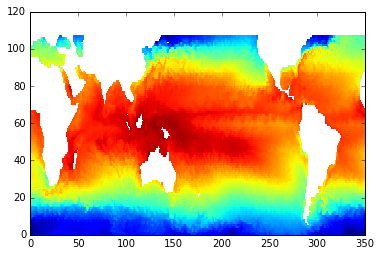

In [156]:
plt.pcolormesh(np.ma.masked_invalid(SSTagg_ex))

In [49]:
ys, ye = (400, 2000)
xs, xe = (0, 3500)
SST1deg = p.aggregate_latlon(lat_interp, lon_interp-180., latbound=60., lonbound=170.)

/usr/local/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


ValueError: zero-size array to reduction operation minimum which has no identity